# Health Models

In [34]:
## Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# sklearn
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# scipy
from scipy.stats import shapiro

# statsmodels
import statsmodels.api as sm

## Optional Variable Selection
Data: quantile transformed and dummy vars

Response variable: health PC1 detrended by all income vars PC1

In [35]:
## Read data
df = pd.read_csv('./data/data_detrend.csv', index_col='CountySt')

## Response variable selection
select_var = 'PCA_dt_allinc'
resp_vars = ['PCT_DIABETES_ADULTS13', 'HDM', 'PCA', 'PCA_dt_medinc', 'PCA_dt_allinc']
df.drop([v for v in resp_vars if v != select_var], axis=1, inplace=True)

## Remove income vars?
rem_income_vars = True
income_vars = ['MEDHHINC15', 'PCT_LACCESS_HHNV15', 'POVRATE15', 'SNAPSPTH12']
if rem_income_vars:
    df.drop(income_vars, axis=1, inplace=True)

## Collinearity Double Check
has_chip_tax and has_food_tax are identical, remove has_chip_tax

In [36]:
# check for collinearity
corr = df.corr().abs().unstack()
corr = corr.sort_values(ascending=False)
print('__________\nCollinear features\n__________')
print('\n'.join([f'{c1}, {c2}: {corr[c1,c2]:.4f}' for c1, c2 in corr.index if c1 != c2 and corr[c1,c2] > 0.7]))

# remove has_chip_tax
df.drop(['has_chip_tax'], axis=1, inplace=True)

__________
Collinear features
__________
has_food_tax, has_chip_tax: 1.0000
has_chip_tax, has_food_tax: 1.0000
sum_farms, DIRSALES_FARMS12: 0.7621
DIRSALES_FARMS12, sum_farms: 0.7621
PCT_LACCESS_POP15, PCT_LACCESS_SNAP15: 0.7544
PCT_LACCESS_SNAP15, PCT_LACCESS_POP15: 0.7544
PCT_HISP10, PCT_NHWHITE10: 0.7062
PCT_NHWHITE10, PCT_HISP10: 0.7062


## Data Partitioning

In [37]:
## X, y
y = df[select_var]
x_cols = [c for c in df.columns if c != select_var]
X = df[x_cols]

## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## Modeling

### LassoCV
Coordinate descent figure code from: <br> https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py

In [38]:
## Fit LassoCV
lassocv = LassoCV(random_state=10, cv=10).fit(X_train, y_train)

#### Alpha selection

Alpha that minimizes MSE = 1.957e-04


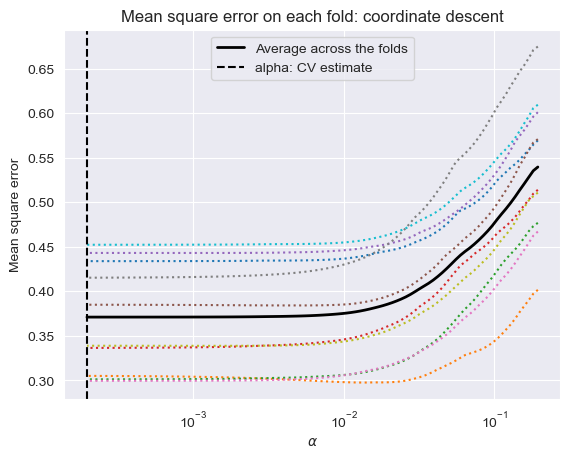

In [39]:
print(f'Alpha that minimizes MSE = {lassocv.alpha_:.3e}')

# plot CV results
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(lassocv.alphas_, lassocv.mse_path_.mean(axis=-1), color="black", label="Average across the folds", linewidth=2)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: coordinate descent")
plt.savefig('data/figures/lassocv coordinate descent.png')
plt.show()

#### Check normality in residuals

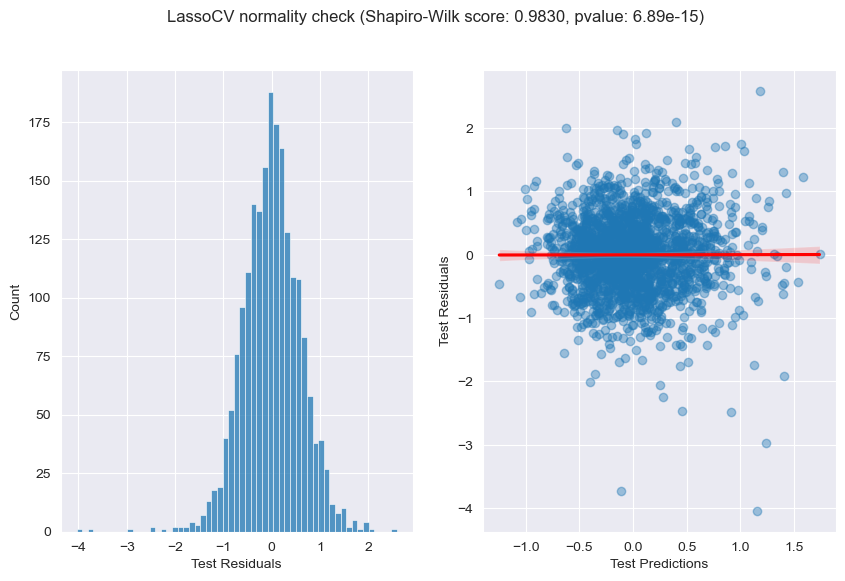

In [40]:
# plot residuals
def check_residuals(X, y, model, save=None):
    pred = model.predict(X)
    res = y - pred
    norm = shapiro(res)
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    sns.histplot(res, ax=axs[0])
    sns.regplot(x=pred, y=res, ax=axs[1], scatter_kws={'alpha':0.4}, line_kws=dict(color="r"))
    axs[0].set_xlabel('Test Residuals')
    axs[1].set_xlabel('Test Predictions')
    axs[1].set_ylabel('Test Residuals')
    fig.suptitle(f'{save} (Shapiro-Wilk score: {norm[0]:.4f}, pvalue: {norm[1]:.2e})')
    if save is not None:
        plt.savefig(f'data/figures/{save}.png')
    plt.show()

check_residuals(X_train, y_train, lassocv, save='LassoCV normality check')

#### Variable selection
No features were removed by LASSO

In [41]:
# print training results
def sklearn_training_results(model, X_train, y_train, has_alpha=False):
    print(f'________ \n{model} \n________')
    if has_alpha:
        alpha = model.alpha_
        print(f'Best alpha: {alpha:.4e}')
    coefs = pd.DataFrame({'feature': X_train.columns, 'coefficients': model.coef_})
    print(f'Top positive coefficients: \n{coefs.sort_values(ascending=False, by='coefficients').head()}')
    print(f'Top negative coefficients: \n{coefs.sort_values(ascending=True, by='coefficients').head()}')
    print(f'# zero coefs = {coefs[coefs['coefficients']==0].shape[0]}, # nonzero coefs = {coefs[coefs['coefficients']!=0].shape[0]} \n{coefs.loc[coefs['coefficients'] == 0, 'feature']}')
    print(f'Training R2: {model.score(X_train, y_train):.4f}')
    
sklearn_training_results(lassocv, X_train, y_train, has_alpha=True)

________ 
LassoCV(cv=10, random_state=10) 
________
Best alpha: 1.9569e-04
Top positive coefficients: 
                     feature  coefficients
4                 PCT_HISP10      0.148254
10       healthy_store_ratio      0.123090
17                 has_fmrkt      0.113912
11  healthy_restaurant_ratio      0.089765
12                 sum_farms      0.080761
Top negative coefficients: 
                   feature  coefficients
3            PCT_65OLDER10     -0.242751
2          PCT_18YOUNGER10     -0.236779
9   2010_Census_Population     -0.189635
13            has_food_tax     -0.181479
7            PCT_NHBLACK10     -0.155693
# zero coefs = 0, # nonzero coefs = 18 
Series([], Name: feature, dtype: object)
Training R2: 0.3248


### Linear Regression
Fit linear regression model with all features with statsmodels and sklearn


#### Sklearn Linear Regression
Nearly identical to LassoCV results.

In [42]:
## Fit linear regression model
lm = LinearRegression().fit(X_train, y_train)

# print results
sklearn_training_results(lm, X_train, y_train)

________ 
LinearRegression() 
________
Top positive coefficients: 
                     feature  coefficients
4                 PCT_HISP10      0.148199
10       healthy_store_ratio      0.123269
17                 has_fmrkt      0.115197
11  healthy_restaurant_ratio      0.089822
12                 sum_farms      0.081090
Top negative coefficients: 
                   feature  coefficients
3            PCT_65OLDER10     -0.243744
2          PCT_18YOUNGER10     -0.237404
9   2010_Census_Population     -0.191479
13            has_food_tax     -0.182067
7            PCT_NHBLACK10     -0.155850
# zero coefs = 0, # nonzero coefs = 18 
Series([], Name: feature, dtype: object)
Training R2: 0.3248


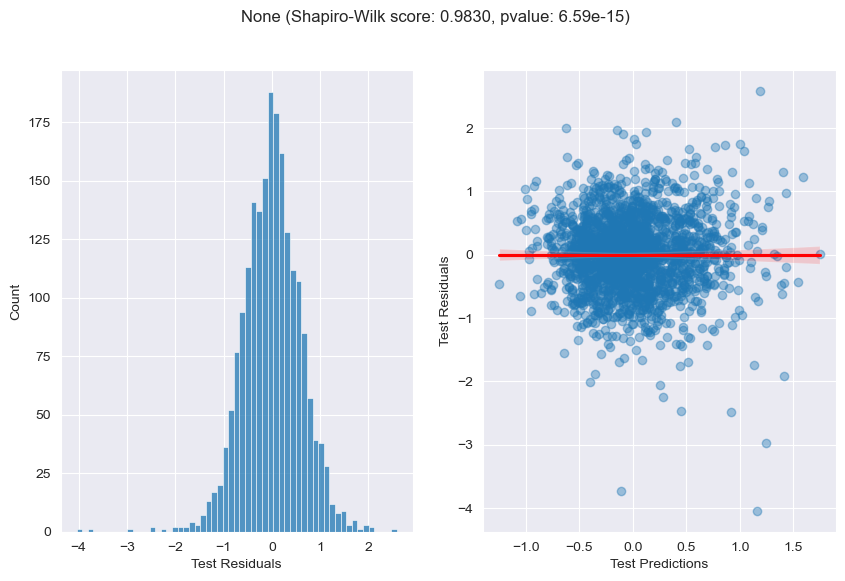

In [43]:
# check normality
check_residuals(X_train, y_train, lm)

#### Statsmodels OLS
Same results again

In [44]:
## Linear regression with statsmodels
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

# top coefficients
print(f'__________\nTop positive coefs: \n__________\n{ols.params.sort_values(ascending=False).head()}')
print(f'__________\nTop negative coefs: \n__________\n{ols.params.sort_values(ascending=True).head()}')

                                 OLS Regression Results                                
Dep. Variable:          PCA_dt_allinc   R-squared (uncentered):                   0.324
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              54.07
Date:                Fri, 06 Dec 2024   Prob (F-statistic):                   9.36e-158
Time:                        14:39:40   Log-Likelihood:                         -1868.4
No. Observations:                2044   AIC:                                      3773.
Df Residuals:                    2026   BIC:                                      3874.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

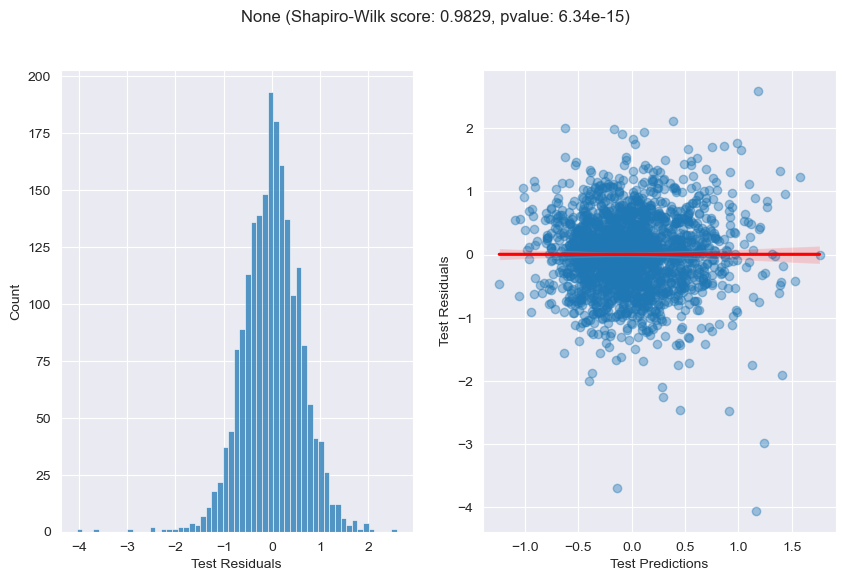

In [45]:
# check normality
check_residuals(X_train, y_train, ols)

### Random Forest

In [46]:
## RandomForest
rfm = RandomForestRegressor(random_state=10, oob_score=True).fit(X_train, y_train)
var_imp = pd.DataFrame({'features': X_train.columns, 'importance': rfm.feature_importances_})
print(f'__________\nRandom Forest Regressor \n__________ \nOOB score: {rfm.oob_score_:.4f}')
print(f'Top 10 most important features\n{var_imp.sort_values('importance', ascending=False)[:10]}')

__________
Random Forest Regressor 
__________ 
OOB score: 0.3681
Top 10 most important features
                    features  importance
4                 PCT_HISP10    0.143502
2            PCT_18YOUNGER10    0.116367
7              PCT_NHBLACK10    0.100192
3              PCT_65OLDER10    0.096607
10       healthy_store_ratio    0.085429
11  healthy_restaurant_ratio    0.066938
5          PCT_LACCESS_POP15    0.063746
8              PCT_NHWHITE10    0.063568
12                 sum_farms    0.053408
6         PCT_LACCESS_SNAP15    0.051379
